# Проект: Анализ покупок в интернет-магазине

## Цель: 
Изучить поведение клиентов на основе данных о покупках, чтобы определить причины низкого уровня удержания и улучшить стратегии маркетинга и логистики.

## Задачи:
* Узнать, сколько пользователей сделали только одну покупку, чтобы понять, почему они не возвращаются.
* Посчитать, сколько заказов не было доставлено в месяц и выяснить причины, чтобы улучшить доставку. 
* Определить, в какие дни недели товары покупают чаще всего, чтобы лучше планировать акции и запасы.
* Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам), чтобы понять их активность.
* Провести когортный анализ, изучить группы пользователей за год и найти ту, которая лучше всего удерживается на 3-й месяц.
* Выполнить RFM-сегментацию клиентов по трем критериям: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Для каждого RFM-сегмента нужно построить границы метрик recency, frequency и monetary для интерпретации этих кластеров. 

## Дано:

**Датасет «пользователи»**: содержит информацию о клиентах интернет-магазина.
- customer_id — позаказный идентификатор пользователя
- customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)
- customer_zip_code_prefix —  почтовый индекс пользователя
- customer_city —  город доставки пользователя
- customer_state —  штат доставки пользователя
  
**Датасет «заказы»**: включает данные о заказах, их статусы, время создания, доставки и оплаты.
- order_id —  уникальный идентификатор заказа (номер чека)
- customer_id —  позаказный идентификатор пользователя
- order_status —  статус заказа
- order_purchase_timestamp —  время создания заказа
- order_approved_at —  время подтверждения оплаты заказа
- order_delivered_carrier_date —  время передачи заказа в логистическую службу
- order_delivered_customer_date —  время доставки заказа
- order_estimated_delivery_date —  обещанная дата доставки

Уникальные статусы заказов в данной таблице:
- created —  создан
- approved —  подтверждён
- invoiced —  выставлен счёт
- processing —  в процессе сборки заказа
- shipped —  отгружен со склада
- delivered —  доставлен пользователю
- unavailable —  недоступен
- canceled —  отменён

**Датасет «товары»**: содержит информацию о товарах в заказах и их цены.
- order_id —  уникальный идентификатор заказа (номер чека)
- order_item_id —  идентификатор товара внутри одного заказа
- product_id —  ид товара (аналог штрихкода)
- seller_id — ид производителя товара
- shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике
- price —  цена за единицу товара
- freight_value —  вес товара

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

In [3]:
customers = pd.read_csv('olist_customers_dataset.csv')

orders = pd.read_csv('olist_orders_dataset.csv', parse_dates=['order_purchase_timestamp', 
                                                              'order_approved_at',
                                                              'order_delivered_carrier_date',
                                                              'order_delivered_customer_date',
                                                              'order_estimated_delivery_date'])

order_items = pd.read_csv('olist_order_items_dataset.csv', parse_dates=['shipping_limit_date'])

### **Задача:** Провести предварительное исследование данных и определить количество пользователей, которые совершили покупку только один раз, т.е. не стали постоянными покупателями.

**Датасет «пользователи».** Смотрю тип данных, количество строк и столбцов, пропущенные значения и дубли:

In [62]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [102]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [104]:
customers.duplicated().sum()

0

In [106]:
customers.customer_id.duplicated().sum()

0

In [108]:
customers.customer_unique_id.duplicated().sum()

3345

Дубли в customer_unique_id вероятнее всего указывают на то, что один и тот же пользователь создал несколько учетных записей. Я проведу дополнительную проверку, чтобы подтвердить это предположение.

In [114]:
customers.groupby('customer_unique_id', as_index=False) \
    .agg({'customer_id': 'nunique'}) \
    .sort_values('customer_id', ascending=False) \
    .query('customer_id >1 ')

,customer_unique_id,customer_id
52973,8d50f5eadf50201ccdcedfb9e2ac8455,17
23472,3e43e6105506432c953e165fb2acf44c,9
37797,6469f99c1f9dfae7733b25662e7f1782,7
76082,ca77025e7201e3b30c44b472ff346268,7
10354,1b6c7548a2a1f9037c1fd3ddfed95f33,7
...,...,...
35047,5cfc9643603c095fd7ed86a50fa17887,2
78003,cfb025f193db116549c9c23e4d58e3e3,2
36416,609b7feab0f0c9726929ec4891447b02,2
94630,fc19fe9ac733e36ff8227c29435c2030,2


2997 пользователей создали более одной учетной записи, при этом максимальное количество аккаунтов на одного пользователя 17. Это похоже на правду, но я дополнительно выборочно проверю записи по пользователям с одинаковым customer_unique_id:

In [121]:
customers.query('customer_unique_id == "8d50f5eadf50201ccdcedfb9e2ac8455"')

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
14186,1bd3585471932167ab72a84955ebefea,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP
15321,a8fabc805e9a10a3c93ae5bff642b86b,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP
16654,897b7f72042714efaa64ac306ba0cafc,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP
36122,b2b13de0770e06de50080fea77c459e6,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP
38073,42dbc1ad9d560637c9c4c1533746f86d,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP
40141,dfb941d6f7b02f57a44c3b7c3fefb44b,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP
48614,65f9db9dd07a4e79b625effa4c868fcb,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP
52574,1c62b48fb34ee043310dcb233caabd2e,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP
58707,a682769c4bc10fc6ef2101337a6c83c9,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP
67996,6289b75219d757a56c0cce8d9e427900,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP


Значения в других столбцах (таких как customer_zip_code_prefix, customer_city, customer_state) совпадают. Это позволяет с уверенностью сделать вывод, что это один и тот же пользователь, но с разными аккаунтами.

**Датасет «заказы».** Смотрю тип данных, количество строк и столбцов, пропущенные значения и дубли:

In [125]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [129]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [131]:
orders.duplicated().sum()

0

In [133]:
orders.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [135]:
orders.sort_values('order_approved_at').tail(10)
# orders.sort_values('order_delivered_carrier_date').tail(10)
# orders.sort_values('order_delivered_customer_date').tail(10)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
93992,b6e63e74aff84a068fdc1b41e9ac29ea,f0375e81392cb7499b1139be16fd21e2,canceled,2018-08-07 10:44:34,NaT,NaT,NaT,2018-08-21
94252,72fcdcc4d106595993b31fc91c800113,89cbb4528dbfd3ec138d5014dc8ccb0e,canceled,2017-09-12 22:36:04,NaT,NaT,NaT,2017-09-22
95451,7813842ae95e8c497fc0233232ae815a,040d94f8ba8ca26014bd6f7e8a6e0c0d,canceled,2018-08-17 20:06:36,NaT,NaT,NaT,2018-09-17
96996,5a14c8b3d919a4ef3f3428b0459c47b2,666094835d60d986eb87350b31efdcae,canceled,2017-05-29 23:53:39,NaT,NaT,NaT,2017-06-23
97100,b34369ee8397436dd7ceb8bb7783671d,c96771504b0c9d89ad8da161e0e3d092,canceled,2017-06-07 20:11:29,NaT,NaT,NaT,2017-07-04
97696,5a00b4d35edffc56b825c3646a99ba9d,6a3bdf004ca96338fb5fad1b8d93c2e6,canceled,2017-07-02 15:38:46,NaT,NaT,NaT,2017-07-25
98415,227c804e2a44760671a6a5697ea549e4,62e7477e75e542243ee62a0ba73f410f,canceled,2017-09-28 15:02:56,NaT,NaT,NaT,2017-10-16
98909,e49e7ce1471b4693482d40c2bd3ad196,e4e7ab3f449aeb401f0216f86c2104db,canceled,2018-08-07 11:16:28,NaT,NaT,NaT,2018-08-10
99283,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaT,NaT,NaT,2018-10-01
99347,a89abace0dcc01eeb267a9660b5ac126,2f0524a7b1b3845a1a57fcf3910c4333,canceled,2018-09-06 18:45:47,NaT,NaT,NaT,2018-09-27


Пропущенные значения возникают в заказах, которые были созданы (все заказы имеют заполненное поле order_purchase_timestamp). Выборочная проверка по столбцам с пропущенными значениями (order_approved_at, order_delivered_carrier_date, order_delivered_customer_date) показывает, что в преобладающем большинстве случаев эти заказы не были выполнены, то есть имеют статус "отменен" или "недоступен". Это вполне нормально. 

Возможные причины: 
- некоторые заказы не были оплачены пользователями (order_approved_at), 
- некоторые заказы еще не были переданы в логистическую службу (order_delivered_carrier_date), 
- некоторые заказы пока еще не были доставлены клиентам (order_delivered_customer_date).

Количество пропущенных значений не превышает 3%

Посмотрю заказы, по которым проставлен статус "доставлен" более внимательно:

In [144]:
orders.query('order_status == "delivered"').isnull().sum()

order_id                          0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_approved_at                14
order_delivered_carrier_date      2
order_delivered_customer_date     8
order_estimated_delivery_date     0
dtype: int64

А вот это проблема, так как заказ со статусом "доставлен" не имеет:
- времени подтверждения оплаты заказа (order_approved_at) в 14 случаях,
- времени передачи заказа в логистическую службу (order_delivered_carrier_date) в 2 случаях,
- времени доставки заказа (order_delivered_customer_date) в 8 случаях.

Посмотрю детальнее на каждый случай: 

In [12]:
orders.query('order_status == "delivered"').sort_values('order_approved_at').tail(14)    

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
5323,e04abd8149ef81b95221e88f6ed9ab6a,2127dc6603ac33544953ef05ec155771,delivered,2017-02-18 14:40:00,NaT,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17
16567,8a9adc69528e1001fc68dd0aaebbb54a,4c1ccc74e00993733742a3c786dc3c1f,delivered,2017-02-18 12:45:31,NaT,2017-02-23 09:01:52,2017-03-02 10:05:06,2017-03-21
19031,7013bcfc1c97fe719a7b5e05e61c12db,2941af76d38100e0f8740a374f1a5dc3,delivered,2017-02-18 13:29:47,NaT,2017-02-22 16:25:25,2017-03-01 08:07:38,2017-03-17
22663,5cf925b116421afa85ee25e99b4c34fb,29c35fc91fc13fb5073c8f30505d860d,delivered,2017-02-18 16:48:35,NaT,2017-02-22 11:23:10,2017-03-09 07:28:47,2017-03-31
23156,12a95a3c06dbaec84bcfb0e2da5d228a,1e101e0daffaddce8159d25a8e53f2b2,delivered,2017-02-17 13:05:55,NaT,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20
26800,c1d4211b3dae76144deccd6c74144a88,684cb238dc5b5d6366244e0e0776b450,delivered,2017-01-19 12:48:08,NaT,2017-01-25 14:56:50,2017-01-30 18:16:01,2017-03-01
38290,d69e5d356402adc8cf17e08b5033acfb,68d081753ad4fe22fc4d410a9eb1ca01,delivered,2017-02-19 01:28:47,NaT,2017-02-23 03:11:48,2017-03-02 03:41:58,2017-03-27
39334,d77031d6a3c8a52f019764e68f211c69,0bf35cac6cc7327065da879e2d90fae8,delivered,2017-02-18 11:04:19,NaT,2017-02-23 07:23:36,2017-03-02 16:15:23,2017-03-22
48401,7002a78c79c519ac54022d4f8a65e6e8,d5de688c321096d15508faae67a27051,delivered,2017-01-19 22:26:59,NaT,2017-01-27 11:08:05,2017-02-06 14:22:19,2017-03-16
61743,2eecb0d85f281280f79fa00f9cec1a95,a3d3c38e58b9d2dfb9207cab690b6310,delivered,2017-02-17 17:21:55,NaT,2017-02-22 11:42:51,2017-03-03 12:16:03,2017-03-20


Отсутствие информации об оплате может означать, что товар был доставлен клиенту, но деньги за него не были уплачены, либо оплата была произведена, но не отображается в CRM-системе. Это искажает реальную картину финансовой отчетности. Возможные причины: 
- сбои в системе,
- умышленное хищение,
- заказ может быть доставлен магазином в качестве замены бракованного товара без доплаты по гарантийным обязательствам.

Посмотрю, что именно было продано без денег:

In [16]:
# Использую метод .isin() для фильтрации
order_items[order_items.order_id.isin([    
            "e04abd8149ef81b95221e88f6ed9ab6a",
            "8a9adc69528e1001fc68dd0aaebbb54a",
            "7013bcfc1c97fe719a7b5e05e61c12db",
            "5cf925b116421afa85ee25e99b4c34fb",
            "12a95a3c06dbaec84bcfb0e2da5d228a",
            "c1d4211b3dae76144deccd6c74144a88",
            "d69e5d356402adc8cf17e08b5033acfb",
            "d77031d6a3c8a52f019764e68f211c69",
            "7002a78c79c519ac54022d4f8a65e6e8",
            "2eecb0d85f281280f79fa00f9cec1a95",
            "51eb2eebd5d76a24625b31c33dd41449",
            "88083e8f64d95b932164187484d90212",
            "3c0b8706b065f9919d0505d3b3343881",
            "2babbb4b15e6d2dfe95e2de765c97bce"
])].sort_values('product_id')

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
94999,d77031d6a3c8a52f019764e68f211c69,1,02a79d79e818ad0be36cfc843a6af7ad,cb3dd9ce66268c7a3ca7241ac70ab58c,2017-02-25 10:04:19,28.99,10.96
98863,e04abd8149ef81b95221e88f6ed9ab6a,1,0e20a07ca1714df21f9b07ca3bf7c682,4e7c18b98d84e05cbae3ff0ff03846c2,2017-02-22 13:40:00,309.90,39.11
60815,8a9adc69528e1001fc68dd0aaebbb54a,1,2c2b6a28924791234bd386bddb17512e,a4b6b9b992b46e9ef863637af96e04bc,2017-02-22 11:45:31,379.00,17.86
20473,2eecb0d85f281280f79fa00f9cec1a95,1,4fd676d9c4723d475026e40aeae56957,5fd924b4836098a5be0ecf81ba054ce0,2017-02-21 16:21:55,135.00,19.23
49336,7013bcfc1c97fe719a7b5e05e61c12db,1,583916a5dae918f5e89baec139141c54,3481aa57cd91f9f9d3fa1fa12d9a3bf7,2017-02-22 12:29:47,49.99,15.53
85300,c1d4211b3dae76144deccd6c74144a88,1,5ab02ca028398131a5ae91401eb49788,80e6699fe29150b372a0c8a1ebf7dcc8,2017-01-23 12:48:08,39.99,14.52
36128,51eb2eebd5d76a24625b31c33dd41449,1,7868a64aa111bbb4f41f8e1146c0becb,cca3071e3e9bb7d12640c9fbe2301306,2017-02-28 14:52:27,59.90,17.16
59699,88083e8f64d95b932164187484d90212,1,8c5876b1c7768217964f353bc7e64393,0db783cfcd3b73998abc6e10e59a102f,2017-02-22 21:49:19,49.00,14.52
59700,88083e8f64d95b932164187484d90212,2,8c5876b1c7768217964f353bc7e64393,0db783cfcd3b73998abc6e10e59a102f,2017-02-22 21:49:19,49.00,14.52
49309,7002a78c79c519ac54022d4f8a65e6e8,1,c3b271f47e73d0c9ccf1b43b7606c705,cca3071e3e9bb7d12640c9fbe2301306,2017-01-29 22:26:59,45.90,14.52


Закономерности встречаются (несколько одинаковых товаров), но их немного. Нельзя на основе этих данных сделать вывод о природе данной ошибки, поэтому список ID заказов будет передан менеджеру интернет-магазина для дополнительной проверки на предмет необходимости оплаты этих заказов клиентами.

Далее смотрю почему нет времени передачи заказа в логистическую службу:

In [20]:
orders.query('order_status == "delivered"').sort_values('order_delivered_carrier_date').tail(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
73222,2aa91108853cecb43c84a5dc5b277475,afeb16c7f46396c0ed54acb45ccaaa40,delivered,2017-09-29 08:52:58,2017-09-29 09:07:16,NaT,2017-11-20 19:44:47,2017-11-14
92643,2d858f451373b04fb5c984a1cc2defaf,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,NaT,NaT,2017-06-23


Оба заказа были оплачены, но нет информации о том, что они были переданы в службу доставки. Причем один из заказов имеет дату доставки клиенту, а второй нет. Проверю есть ли закономерности по данным заказам если посмотреть на product_id:

In [25]:
order_items.query('order_id== "2aa91108853cecb43c84a5dc5b277475" | order_id== "2d858f451373b04fb5c984a1cc2defaf"')

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
18554,2aa91108853cecb43c84a5dc5b277475,1,44c2baf621113fa7ac95fa06b4afbc68,3f2af2670e104d1bcb54022274daeac5,2017-10-18 10:07:16,179.0,14.98
19838,2d858f451373b04fb5c984a1cc2defaf,1,30b5b5635a79548a48d04162d971848f,f9bbdd976532d50b7816d285a22bd01e,2017-06-04 23:30:16,179.0,15.00


Выявлена закономерность по цене и весу. Возможно, это один и тот же товар, несмотря на то что product_id отличается. Он может отличаться, так как в описании датасета сказано, что это аналог штрих-кода, следовательно, он должен быть уникальным. Может быть это один и тот же клиент под разными учетными записями, который не смог получить товар в первый раз и заказал его повторно?

In [32]:
customers.query('customer_id == "afeb16c7f46396c0ed54acb45ccaaa40" | customer_id == "e08caf668d499a6d643dafd7c5cc498a"')

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
86959,afeb16c7f46396c0ed54acb45ccaaa40,a2ac81ecc3704410ae240e74d4f0af40,13334,indaiatuba,SP
97677,e08caf668d499a6d643dafd7c5cc498a,d77cf4be2654aa70ef150f8bfec076a6,91330,porto alegre,RS


Нет, это разные клиенты. Данные о месте проживания клиента опровергают эту гипотезу. Возможно, заказ был доставлен другим способом, в обход логистической службы, или произошел технический сбой.

Смотрю последний случай, когда заказ был доставлен, но нет информации о дате доставки клиенту:

In [39]:
orders.query('order_status == "delivered"').sort_values('order_delivered_customer_date').tail(8)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
3002,2d1e2d5bf4dc7227b3bfebb81328c15f,ec05a6d8558c6455f0cbbd8a420ad34f,delivered,2017-11-28 17:44:07,2017-11-28 17:56:40,2017-11-30 18:12:23,NaT,2017-12-18
20618,f5dd62b788049ad9fc0526e3ad11a097,5e89028e024b381dc84a13a3570decb4,delivered,2018-06-20 06:58:43,2018-06-20 07:19:05,2018-06-25 08:05:00,NaT,2018-07-16
43834,2ebdfc4f15f23b91474edf87475f108e,29f0540231702fda0cfdee0a310f11aa,delivered,2018-07-01 17:05:11,2018-07-01 17:15:12,2018-07-03 13:57:00,NaT,2018-07-30
79263,e69f75a717d64fc5ecdfae42b2e8e086,cfda40ca8dd0a5d486a9635b611b398a,delivered,2018-07-01 22:05:55,2018-07-01 22:15:14,2018-07-03 13:57:00,NaT,2018-07-30
82868,0d3268bad9b086af767785e3f0fc0133,4f1d63d35fb7c8999853b2699f5c7649,delivered,2018-07-01 21:14:02,2018-07-01 21:29:54,2018-07-03 09:28:00,NaT,2018-07-24
92643,2d858f451373b04fb5c984a1cc2defaf,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,NaT,NaT,2017-06-23
97647,ab7c89dc1bf4a1ead9d6ec1ec8968a84,dd1b84a7286eb4524d52af4256c0ba24,delivered,2018-06-08 12:09:39,2018-06-08 12:36:39,2018-06-12 14:10:00,NaT,2018-06-26
98038,20edc82cf5400ce95e1afacc25798b31,28c37425f1127d887d7337f284080a0f,delivered,2018-06-27 16:09:12,2018-06-27 16:29:30,2018-07-03 19:26:00,NaT,2018-07-19


Вероятнее всего, также имеет место технический сбой, так как гипотеза о том, что заказ был доставлен другим способом, в данном случае несостоятельна, поскольку заказ был передан ранее в службу доставки.

Возможно, шрих-код на товарах был поврежден, в результате чего курьер службы доставки не смог считать код, а статус заказа изменили на "доставлен" позже, в ручном режиме
.
Так или иначе, ID эт х заказ в также можно отправить в технический отдел, чтобы они знали о возможных проблемх. 

In [55]:
min_order_purchase_timestamp = orders.order_purchase_timestamp.min()
max_order_purchase_timestamp = orders.order_purchase_timestamp.max()
print(f"Период покупок: от {min_order_purchase_timestamp} до {max_order_purchase_timestamp}")

Период покупок: от 2016-09-04 21:15:19 до 2018-10-17 17:30:18


**Датасет «товары».** Смотрю тип данных, количество строк и столбцов, пропущенные значения и дубли:

In [93]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


Пример структуры данных:

In [62]:
order_items.query('order_id == "00143d0f86d6fbd9f9b38ab440ac16f5"')

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
32,00143d0f86d6fbd9f9b38ab440ac16f5,1,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
33,00143d0f86d6fbd9f9b38ab440ac16f5,2,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
34,00143d0f86d6fbd9f9b38ab440ac16f5,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1


In [64]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  int64         
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.0+ MB


In [66]:
order_items.duplicated().sum()

0

In [70]:
order_items.price.min()

0.85

На все товары есть цена 

In [73]:
order_items.query('freight_value == 0').shape

(383, 7)

Есть товары с нулевым весом. Это нормально, т.к. это могут быть цифровые товары или услуги.

In [89]:
max_order_items = order_items.order_item_id.max()
print(f"Максимальное количество товарных позиций в заказе: {max_order_items}") 

Максимальное количество товарных позиций в заказе: 21


**ИТОГО:** по результатам предварительного исследования данных я решил считать покупкой уникального клиента (customer_unique_id), которому был доставлен хотя бы один заказ (order_status == delivered), а также заполнены все обязательные для анализа поля: время создания заказа, время подтверждения оплаты, время передачи заказа в логистическую службу и время доставки заказа, т.к. целью анализа является изучение процесса покупок и непольные данные могут усложнить предстоящее исследование. Таких записей крайне мало, поэтому они не смогут исказить выводы в целом. При исследовании пользователей, я учитываю только уникальных пользователей, чтобы избежать искажения данных из-за дубликатов.

In [26]:
customers_and_orders = customers.merge(orders, on ='customer_id')


one_order_customers = customers_and_orders \
    .query(
          'order_status == "delivered" and '
          'order_approved_at.notna() and '
          'order_delivered_carrier_date.notna() and '
          'order_delivered_customer_date.notna()'
          ) \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'order_status': 'count'}) \
    .query('order_status == 1')

print(f"{one_order_customers.shape[0]} уникальных пользователей совершили покупку только один раз.")

90536 уникальных пользователей совершили покупку только один раз.


### **Задача:**  Посчитать, сколько заказов не было доставлено в месяц и выяснить причины, чтобы улучшить доставку. 

In [102]:
orders['month'] = orders.order_purchase_timestamp.dt.strftime('%Y-%m')

unsuccessful_orders = orders.query('order_status == "canceled" or order_status == "unavailable"') \
    .groupby(['month', 'order_status'], as_index=False) \
    .agg({'order_id': 'count'}) \
    .pivot(index='month', columns='order_status', values='order_id')

unsuccessful_orders = unsuccessful_orders.fillna(0)

print(f"{unsuccessful_orders}")

order_status  canceled  unavailable
month                              
2016-09            2.0          0.0
2016-10           24.0          7.0
2017-01            3.0         10.0
2017-02           17.0         45.0
2017-03           33.0         32.0
2017-04           18.0          9.0
2017-05           29.0         31.0
2017-06           16.0         24.0
2017-07           28.0         52.0
2017-08           27.0         32.0
2017-09           20.0         38.0
2017-10           26.0         58.0
2017-11           37.0         84.0
2017-12           11.0         42.0
2018-01           34.0         48.0
2018-02           73.0         30.0
2018-03           26.0         17.0
2018-04           15.0          5.0
2018-05           24.0         16.0
2018-06           18.0          4.0
2018-07           41.0         18.0
2018-08           84.0          7.0
2018-09           15.0          0.0
2018-10            4.0          0.0


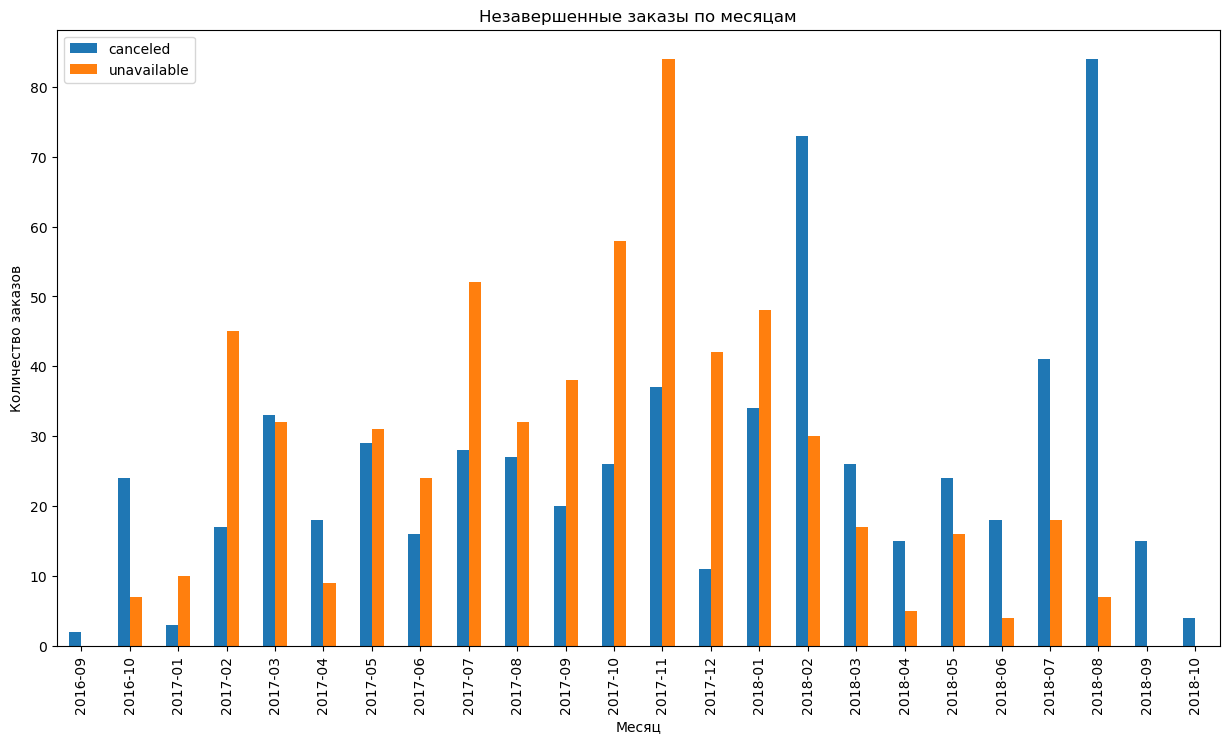

In [106]:
unsuccessful_orders.plot(kind='bar', figsize=(15, 8))
plt.title('Незавершенные заказы по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.legend()
plt.show()

Предварительный анализ данных интернет-магазина за 2017-2018 годы выявил проблемы с доступностью товаров в 2017 году, что отражается в преобладании статуса 'unavailable' в заказах. В 2018 году ситуация изменилась, и стало больше отмененных заказов, что может быть связано с изменением политики магазина или поведения покупателей.

Дальнейший анализ может помочь в понимании причин этих изменений и выявлении других тенденций. В частности, интересно изучить, связано ли увеличение незавершенных заказов с общим ростом заказов в магазине, и какие факторы привели к пикам ошибок в ноябре 2017 года и августе 2018 года.

### **Задача:**  Определить, в какие дни недели товары покупают чаще всего

In [10]:
# Объединяю таблицы заказов и товаров
orders_items = orders.merge(order_items, on='order_id')

# Создаю новый столбец с днем недели
orders_items['day_of_week'] = orders_items['order_purchase_timestamp'].dt.day_name()

# Выполняю группировку по товару и дню недели, считаю кол-во покупок для каждого product_id в каждый день недели
product_day_counts = orders_items \
                    .groupby(['product_id', 'day_of_week']) \
                    .agg({'order_item_id': 'count'}) \
                    .rename(columns={'order_item_id': 'purchase_count'}) \
                    .sort_values('purchase_count', ascending=False)

product_day_counts

purchase_count
product_id                       day_of_week                
422879e10f46682990de24d770e7f83d Wednesday                93
99a4788cb24856965c36a24e339b6058 Monday                   92
aca2eb7d00ea1a7b8ebd4e68314663af Thursday                 89
                                 Friday                   87
                                 Tuesday                  85
...                                                      ...
642369377615febc7fa89e4c8df5110e Thursday                  1
642a40d4d73b4b2604968937de13634a Sunday                    1
642e125cbc752b4eeb8faf442319c39f Thursday                  1
64315bd8c0c47303179dd2e25b579d00 Saturday                  1
fffe9eeff12fcbd74a2f2b007dde0c58 Wednesday                 1

[61230 rows x 1 columns]

В данной задаче я сознательно не использовал фильтрацию по статусу "delivered", т.к. ставил цель изучить интерес покупателя к товару, даже если после этого заказ будет отменен. 

На этом этапе можно изучить сколько товаров (product_id) продается в каждый день недели (day_of_week)

In [17]:
# Нахожу максимальное количество покупок для каждого product_id по каждому дню недели
max_purchase_days = product_day_counts.groupby('product_id')['purchase_count'].transform('max') == product_day_counts['purchase_count']
max_purchase_days

product_id                        day_of_week
422879e10f46682990de24d770e7f83d  Wednesday       True
99a4788cb24856965c36a24e339b6058  Monday          True
aca2eb7d00ea1a7b8ebd4e68314663af  Thursday        True
                                  Friday         False
                                  Tuesday        False
                                                 ...  
642369377615febc7fa89e4c8df5110e  Thursday       False
642a40d4d73b4b2604968937de13634a  Sunday         False
642e125cbc752b4eeb8faf442319c39f  Thursday        True
64315bd8c0c47303179dd2e25b579d00  Saturday       False
fffe9eeff12fcbd74a2f2b007dde0c58  Wednesday       True
Name: purchase_count, Length: 61230, dtype: bool

In [21]:
# Выполняю фильтрацию строк: оставляю только те строки, где значение (или несколько значений) максимальное, т.е. = True   
filtered_product_day_counts = product_day_counts[max_purchase_days]
filtered_product_day_counts

purchase_count
product_id                       day_of_week                
422879e10f46682990de24d770e7f83d Wednesday                93
99a4788cb24856965c36a24e339b6058 Monday                   92
aca2eb7d00ea1a7b8ebd4e68314663af Thursday                 89
53b36df67ebb7c41585e8d54d6772e08 Tuesday                  76
389d119b48cf3043d311335e499d9c6b Thursday                 67
...                                                      ...
6421ae053bb80dff3ceae1f217f54ed4 Monday                    1
642247ccf62585635cefa1bf09f59b94 Sunday                    1
                                 Tuesday                   1
642e125cbc752b4eeb8faf442319c39f Thursday                  1
fffe9eeff12fcbd74a2f2b007dde0c58 Wednesday                 1

[42705 rows x 1 columns]

На этом этапе оставил только дни недели, где для каждого product_id значение purchase_count является максимальным. Я учел тот факт, что максимальному значению может соответвовать сразу несколько дней недели. 

In [23]:
# Группирую по дню недели и считаю количество записей
day_of_week_counts = filtered_product_day_counts.groupby('day_of_week').size().sort_values(ascending=False)
day_of_week_counts

day_of_week
Monday       6982
Tuesday      6851
Wednesday    6746
Thursday     6285
Friday       6058
Sunday       5103
Saturday     4680
dtype: int64

Ответ: Чаще всего товары покупают в понедельник.  

### **Задача:**  Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? 

In [71]:
# Объединяю таблицы и фильтрую заказы, которые считаются покупками
customers_and_orders = customers.merge(orders, on='customer_id')

valid_purchases = customers_and_orders.query(
    'order_status == "delivered" and '
    'order_approved_at.notna() and '
    'order_delivered_carrier_date.notna() and '
    'order_delivered_customer_date.notna()'
).copy()  # Создаю копию датафрейма, чтобы не ловить ошибку SettingWithCopyWarning

# Создаю новый столбец на основе столбца "время создания заказа"
valid_purchases.loc[:, 'month'] = valid_purchases.order_purchase_timestamp.dt.strftime('%Y-%m')

# Вычисляю количество недель в каждом месяце
valid_purchases.loc[:, 'weeks'] = valid_purchases['order_purchase_timestamp'].dt.days_in_month / 7

# Промежуточный результат:
valid_purchases[['customer_unique_id', 'order_purchase_timestamp', 'month', 'weeks']].head(10)

,customer_unique_id,order_purchase_timestamp,month,weeks
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:05:35,2017-05,4.428571
1,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:48:24,2018-01,4.428571
2,060e732b5b29e8181a18229c7b0b2b5e,2018-05-19 16:07:45,2018-05,4.428571
3,259dac757896d24d7702b9acbbff3f3c,2018-03-13 16:06:38,2018-03,4.428571
4,345ecd01c38d18a9036ed96c73b8d066,2018-07-29 09:51:30,2018-07,4.428571
5,4c93744516667ad3b8f1fb645a3116a4,2017-09-14 18:14:31,2017-09,4.285714
6,addec96d2e059c80c30fe6871d30d177,2018-02-19 14:38:35,2018-02,4.000000
7,57b2a98a409812fe9618067b6b8ebe4f,2017-11-16 19:29:02,2017-11,4.285714
8,1175e95fb47ddff9de6b2b06188f7e0d,2018-01-18 12:35:44,2018-01,4.428571
9,9afe194fb833f79e300e37e580171f22,2018-01-08 11:22:34,2018-01,4.428571


Я понимаю, что кол-во недель будет дробным числом, когда кол-во дней в месяце больше 28. Однако это не повлияет на итоговый результат, т.к. позже я буду считать среднее значение в неделю на основании данных покупок за месяц. 

In [74]:
# Выполняю группировку по уникальным пользователям и месяцам. Считаю кол-во заказов для каждой группы
monthly_purchases = valid_purchases.groupby(['customer_unique_id', 'month', 'weeks']) \
                                   .agg({'order_id': 'count'}) \
                                   .reset_index()

monthly_purchases.sort_values('order_id', ascending = False)

,customer_unique_id,month,weeks,order_id
7099,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01,4.428571,6
74543,c8460e4251689ba205045f3ea17884a1,2018-08,4.428571,4
23216,3e43e6105506432c953e165fb2acf44c,2018-02,4.000000,4
65757,b08fab27d47a1eb6deda07bfd965ad43,2017-09,4.285714,4
14054,25a560b9a6006157838aab1bdbd68624,2017-04,4.285714,4
...,...,...,...,...
31892,55a44284e2c362a0199fb0df3ea9fb7d,2017-09,4.285714,1
31891,55a36ff7f14abc01688647c613b35836,2017-12,4.428571,1
31890,55a36fca00cebb9272a8e7d5b8325f59,2017-05,4.428571,1
31889,55a34f9f352e3c1ef564fc7855a1b7e9,2018-07,4.428571,1


In [76]:
# Считаю среднее количество покупок в неделю
monthly_purchases['avg_weekly_purchases'] = (monthly_purchases['order_id'] / monthly_purchases['weeks']).fillna(0).round(2)

# Промежуточный результат:
monthly_purchases.sort_values('order_id', ascending = False)

,customer_unique_id,month,weeks,order_id,avg_weekly_purchases
7099,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01,4.428571,6,1.35
74543,c8460e4251689ba205045f3ea17884a1,2018-08,4.428571,4,0.90
23216,3e43e6105506432c953e165fb2acf44c,2018-02,4.000000,4,1.00
65757,b08fab27d47a1eb6deda07bfd965ad43,2017-09,4.285714,4,0.93
14054,25a560b9a6006157838aab1bdbd68624,2017-04,4.285714,4,0.93
...,...,...,...,...,...
31892,55a44284e2c362a0199fb0df3ea9fb7d,2017-09,4.285714,1,0.23
31891,55a36ff7f14abc01688647c613b35836,2017-12,4.428571,1,0.23
31890,55a36fca00cebb9272a8e7d5b8325f59,2017-05,4.428571,1,0.23
31889,55a34f9f352e3c1ef564fc7855a1b7e9,2018-07,4.428571,1,0.23


In [80]:
# Среднее число покупок в неделю (по месяцам) для каждого уникального пользователя:
monthly_purchases[['customer_unique_id', 'month', 'avg_weekly_purchases']]

,customer_unique_id,month,avg_weekly_purchases
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,0.23
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,0.23
2,0000f46a3911fa3c0805444483337064,2017-03,0.23
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,0.23
4,0004aac84e0df4da2b147fca70cf8255,2017-11,0.23
...,...,...,...
95166,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06,0.23
95167,fffea47cd6d3cc0a88bd621562a9d061,2017-12,0.23
95168,ffff371b4d645b6ecea244b27531430a,2017-02,0.25
95169,ffff5962728ec6157033ef9805bacc48,2018-05,0.23


### **Задача:** Провести когортный анализ, изучить группы пользователей за 2017 год и найти ту, которая лучше всего удерживается на 3-й месяц.

In [108]:
# Объединяю таблицы и фильтрую заказы, которые считаются покупками 
customers_and_orders = customers.merge(orders, on ='customer_id')

valid_purchases = customers_and_orders \
    .query(
          'order_status == "delivered" and '
          'order_approved_at.notna() and '
          'order_delivered_carrier_date.notna() and '
          'order_delivered_customer_date.notna()'
          ).copy()  # Создаю копию датафрейма, чтобы не ловить ошибку SettingWithCopyWarning

# Создаю новый столбец на основе столбца "время создания заказа" (код из задачи 2)
valid_purchases['month']  = valid_purchases.order_purchase_timestamp.dt.strftime('%Y-%m')


# Создаю столбец с первой покупкой уникальным пользователем. Сразу преобразую его к нужному формату
valid_purchases['first_purchase'] = valid_purchases.groupby('customer_unique_id') \
                                                   .order_approved_at.transform('min') \
                                                   .dt.strftime('%Y-%m')

# Считаю количество уникальных покупателей, которые совершили первую покупку в данном месяце 
cohort = valid_purchases \
    .groupby('first_purchase', as_index=False) \
    .agg({'customer_unique_id': 'nunique'}) \
    .rename(columns={'customer_unique_id': 'customer_count'})


# Преобразую столбцы 'month' и 'first_purchase' обратно в формат datetime для рассчета столбца 'step'
valid_purchases['month'] = pd.to_datetime(valid_purchases['month'])
valid_purchases['first_purchase'] = pd.to_datetime(valid_purchases['first_purchase'])

# Создаю столбец 'step', который будет разницей между текущим и первым месяцем
valid_purchases['step'] = (
    (valid_purchases['month'].dt.year - valid_purchases['first_purchase'].dt.year) * 12 
    + valid_purchases['month'].dt.month 
    - valid_purchases['first_purchase'].dt.month
)

# Чтобы  'step' начинался с нуля, а не минус единицы 
valid_purchases = valid_purchases[valid_purchases['step'] >= 0]

# Получаю количество уникальных покупателей для каждого шага в 1 месяц
cohort = valid_purchases \
    .groupby(['first_purchase', 'step']) \
    .agg({'customer_unique_id': 'nunique'}) \
    .rename(columns={'customer_unique_id': 'customer_count'})

# Перевожу столбец 'first_purchase' обратно в формат '%Y-%m'
cohort.reset_index(inplace=True)
cohort['first_purchase'] = cohort['first_purchase'].dt.strftime('%Y-%m')

# Фильтрую когорты, убираю 2016 и 2018 годы, т.к. по ним мало данных:
cohort = cohort[~cohort['first_purchase'].str.startswith(('2016-', '2018-'))]

# Использую pivot для изменения формата таблицы
cohort = cohort.pivot(index='first_purchase', columns='step', values='customer_count')

cohort

step,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19
first_purchase,,,,,,,,,,,,,,,,,,,
2017-01,683.0,2.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,NaN,3.0,1.0,5.0,3.0,1.0,1.0,2.0,3.0,1.0
2017-02,1580.0,3.0,5.0,2.0,7.0,2.0,4.0,3.0,1.0,3.0,2.0,5.0,2.0,3.0,2.0,1.0,1.0,3.0,NaN
2017-03,2475.0,11.0,9.0,9.0,9.0,4.0,4.0,8.0,8.0,2.0,9.0,3.0,5.0,3.0,4.0,6.0,2.0,3.0,NaN
2017-04,2204.0,14.0,5.0,4.0,5.0,6.0,8.0,7.0,7.0,4.0,5.0,2.0,1.0,1.0,2.0,2.0,3.0,NaN,NaN
2017-05,3400.0,17.0,16.0,11.0,10.0,11.0,14.0,5.0,9.0,10.0,9.0,12.0,7.0,1.0,6.0,7.0,NaN,NaN,NaN
2017-06,2994.0,15.0,12.0,13.0,9.0,11.0,11.0,7.0,4.0,6.0,9.0,12.0,5.0,5.0,7.0,NaN,NaN,NaN,NaN
2017-07,3666.0,20.0,12.0,8.0,12.0,7.0,12.0,4.0,7.0,9.0,8.0,11.0,5.0,9.0,NaN,NaN,NaN,NaN,NaN
2017-08,3995.0,28.0,14.0,11.0,15.0,21.0,11.0,11.0,7.0,5.0,10.0,8.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,3963.0,28.0,21.0,11.0,18.0,10.0,9.0,9.0,12.0,7.0,10.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [112]:
# Рассчитываю Retention, делю на первую колонку и умножаю на 100 для процента
retention = cohort.divide(cohort.iloc[:, 0], axis=0) * 100   

# Заменяю NaN на 0 для удобства отображения
retention.fillna(0, inplace=True)

# Округляю до сотых
retention = retention.round(2)

retention

step,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19
first_purchase,,,,,,,,,,,,,,,,,,,
2017-01,100.0,0.29,0.29,0.15,0.44,0.15,0.44,0.15,0.15,0.00,0.44,0.15,0.73,0.44,0.15,0.15,0.29,0.44,0.15
2017-02,100.0,0.19,0.32,0.13,0.44,0.13,0.25,0.19,0.06,0.19,0.13,0.32,0.13,0.19,0.13,0.06,0.06,0.19,0.00
2017-03,100.0,0.44,0.36,0.36,0.36,0.16,0.16,0.32,0.32,0.08,0.36,0.12,0.20,0.12,0.16,0.24,0.08,0.12,0.00
2017-04,100.0,0.64,0.23,0.18,0.23,0.27,0.36,0.32,0.32,0.18,0.23,0.09,0.05,0.05,0.09,0.09,0.14,0.00,0.00
2017-05,100.0,0.50,0.47,0.32,0.29,0.32,0.41,0.15,0.26,0.29,0.26,0.35,0.21,0.03,0.18,0.21,0.00,0.00,0.00
2017-06,100.0,0.50,0.40,0.43,0.30,0.37,0.37,0.23,0.13,0.20,0.30,0.40,0.17,0.17,0.23,0.00,0.00,0.00,0.00
2017-07,100.0,0.55,0.33,0.22,0.33,0.19,0.33,0.11,0.19,0.25,0.22,0.30,0.14,0.25,0.00,0.00,0.00,0.00,0.00
2017-08,100.0,0.70,0.35,0.28,0.38,0.53,0.28,0.28,0.18,0.13,0.25,0.20,0.13,0.00,0.00,0.00,0.00,0.00,0.00
2017-09,100.0,0.71,0.53,0.28,0.45,0.25,0.23,0.23,0.30,0.18,0.25,0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00


В период с января по декабрь 2017 нахожу когорту с самым высоким retention на 3-й месяц: 

In [114]:
# Ограничиваю данные периодом с января по декабрь 2017 года
cohort_2017 = cohort.query('"2017-01" <= first_purchase <= "2017-12"')

# Считаю retention на 3-й месяц
retention_month_3 = cohort_2017[2] / cohort_2017[0]

# Нахожу когорту с самым высоким retention на 3-й месяц
highest_cohort_retention_month_3 = retention_month_3.idxmax()

highest_cohort_retention_month_3

'2017-09'

Визуализирую когортную таблицу: 

In [116]:
cohort_2017 = (cohort_2017
            .style
            .set_caption('User retention by cohort')  # добавляем подпись
            .background_gradient(cmap='viridis')  # раскрашиваем ячейки по столбцам
            .highlight_null('white')  # делаем белый фон для значений NaN
            .format("{}", na_rep=""))  # числа форматируем как проценты, NaN заменяем на пустоту
cohort_2017

step,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19
first_purchase,,,,,,,,,,,,,,,,,,,
2017-01,683.0,2.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,,3.0,1.0,5.0,3.0,1.0,1.0,2.0,3.0,1.0
2017-02,1580.0,3.0,5.0,2.0,7.0,2.0,4.0,3.0,1.0,3.0,2.0,5.0,2.0,3.0,2.0,1.0,1.0,3.0,
2017-03,2475.0,11.0,9.0,9.0,9.0,4.0,4.0,8.0,8.0,2.0,9.0,3.0,5.0,3.0,4.0,6.0,2.0,3.0,
2017-04,2204.0,14.0,5.0,4.0,5.0,6.0,8.0,7.0,7.0,4.0,5.0,2.0,1.0,1.0,2.0,2.0,3.0,,
2017-05,3400.0,17.0,16.0,11.0,10.0,11.0,14.0,5.0,9.0,10.0,9.0,12.0,7.0,1.0,6.0,7.0,,,
2017-06,2994.0,15.0,12.0,13.0,9.0,11.0,11.0,7.0,4.0,6.0,9.0,12.0,5.0,5.0,7.0,,,,
2017-07,3666.0,20.0,12.0,8.0,12.0,7.0,12.0,4.0,7.0,9.0,8.0,11.0,5.0,9.0,,,,,
2017-08,3995.0,28.0,14.0,11.0,15.0,21.0,11.0,11.0,7.0,5.0,10.0,8.0,5.0,,,,,,
2017-09,3963.0,28.0,21.0,11.0,18.0,10.0,9.0,9.0,12.0,7.0,10.0,3.0,,,,,,,


### **Задача:** Выполнить RFM-сегментацию клиентов по трем критериям: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Для каждого RFM-сегмента нужно построить границы метрик recency, frequency и monetary для интерпретации этих кластеров. 

In [173]:
# Объединяю все 3 таблицы
df = customers.merge(orders, on ='customer_id').merge(order_items, on ='order_id')
df.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'order_item_id', 'product_id',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')

In [175]:
# Удалил строки с нулевыми значениями
df = df[df != 0].dropna(axis=0, how='any')

In [177]:
# Оставил только заказы со статусом "доставлен", другие сортировки отборы не имеют смысла, т.к. незаполненные строки уже дропнул
df = df.query('order_status == "delivered"')
# df.order_status.unique() #проверка

In [179]:
# Я собираюсь смоделировать анализ, который провожу в реальном времени, установив NOW дату на один день после
# последней покупки. Эта дата будет использоваться в качестве ориентира для расчета Recency score.

# Получаю максимальную дату order_approved_at
max_date = df.order_approved_at.max()

# Конвертирую строку в объект datetime
max_date = pd.to_datetime(max_date)

# Создаю новую дату, которая на 1 день больше максимальной даты
now = max_date.replace(day=max_date.day+1)

now

Timestamp('2018-08-30 15:10:26')

In [181]:
# Считаю RFM-метрики для каждого customer_unique_id
rfm = df.groupby('customer_unique_id').agg({
                                            'order_approved_at': lambda x: (now - x.max()).days,
                                            'order_id':'nunique', 
                                            'price': lambda x: x.sum()  
                                           })

# R - время от последней покупки пользователя до текущей даты (order_approved_at)
# F - количество покупок у пользователя за всё время (order_id)
# M - сумма покупок за всё время (price)

In [182]:
# Переименую столбцы
rfm = rfm.rename(columns={'order_approved_at': 'Recency', 'order_id': 'Frequency', 'price': 'Monetary'})

rfm

,Recency,Frequency,Monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90
0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,18.90
0000f46a3911fa3c0805444483337064,537,1,69.00
0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99
0004aac84e0df4da2b147fca70cf8255,288,1,180.00
...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,447,1,1570.00
fffea47cd6d3cc0a88bd621562a9d061,262,1,64.89
ffff371b4d645b6ecea244b27531430a,568,1,89.90


In [185]:
# Я собираюсь использовать метод квинтилей. Сначала я получаю квинтили для каждого параметра.

quintiles = rfm[['Recency', 'Frequency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'Recency': {0.2: 91.0, 0.4: 177.0, 0.6: 268.0, 0.8: 382.0},
 'Frequency': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 1.0},
 'Monetary': {0.2: 39.9, 0.4: 69.8, 0.6: 109.9, 0.8: 179.9}}

In [187]:
# Присваиваю ранги от 1 до 5. 

def r_score(x):
    if x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1
    
# Меньшее значение Recency лучше, т.к. меньшее значение Recency означает, что пользователь 
# сделал последнюю покупку раньше, т.е. пользователь является более активным.

def fm_score(x, c):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5   
    
# Большее значение Frequency (суммарное количество покупок у пользователя) 
# и Monetary (суммарное количество покупок у пользователя за всё время) лучше

In [189]:
# Теперь я готов получить оценки R, F и M каждого клиента.

rfm['R'] = rfm['Recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['Frequency'].apply(lambda x: fm_score(x, 'Frequency'))
rfm['M'] = rfm['Monetary'].apply(lambda x: fm_score(x, 'Monetary'))

In [191]:
# Объединяю все оценки в один балл
rfm['RFM_score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_score
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,4,1,4,414
0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,18.90,4,1,1,411
0000f46a3911fa3c0805444483337064,537,1,69.00,1,1,2,112
0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,2,1,1,211
0004aac84e0df4da2b147fca70cf8255,288,1,180.00,2,1,5,215


Сегмент: Принцип формирования. Описание

1. Спящие: Recency и Frequency на уровне 1-2. Эти клиенты совершили покупки давно и редко.
2. Под угрозой: Recency на уровне 1-2, Frequency на уровне 3-4. Эти клиенты совершили покупки давно, но делали их относительно часто.
3. Нельзя потерять: Recency на уровне 1-2, Frequency равен 5. Эти клиенты совершили покупки давно, но делали их очень часто.
4. Скоро уснут: Recency на уровне 3, Frequency на уровне 1-2. Эти клиенты совершили покупки недавно, но делали их редко.
5. Требуют внимания: Recency и Frequency на уровне 3. Эти клиенты совершили покупки недавно и делали их среднестатистически.
6. Лояльные клиенты: Recency на уровне 3-4, Frequency на уровне 4-5. Эти клиенты совершили покупки недавно и делали их часто.
7. Перспективные: Recency на уровне 4, Frequency на уровне 1. Эти клиенты совершили покупки недавно, но делали их редко.
8. Новые клиенты: Recency на уровне 5, Frequency на уровне 1. Эти клиенты совершили свою первую покупку недавно.
9. Потенциальные лояльные клиенты: Recency на уровне 4-5, Frequency на уровне 2-3. Эти клиенты совершили покупки недавно и делают их среднестатистически.
10. Чемпионы: Recency и Frequency на уровне 5. Эти клиенты совершили покупки недавно и делают их очень часто.